In [0]:
from helper_functions import customer_hex_id_to_int, mapk
from helper_functions import recall, recall12, mean_recall, calculate_recall_per_customer_batch 
from helper_functions import read_parquet_datasets
from candidate_generation import get_candidates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [75]:
# Read datasets
transactions, customers, articles = read_parquet_datasets()

validation: pd.DataFrame = transactions[transactions.week == transactions.week.max()]
test_week: int = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

transactions_copy = transactions.copy()

# Generating candidates

### Last purchase candidates

In [76]:
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    
candidates_last_purchase = transactions.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks

### Feature engineering
Here we create my three features: mean age per article, highest index_group_name count and mean purchase price of the customer. These features will be used to generate personalized candidates for each customer.

In [77]:
# first create mean price per customer
mean_price_per_c = transactions.groupby('customer_id')['price'].mean().rename('mean_price_per_c').reset_index()
# figure out the customers preferred index group name by looking at past transactions articles' index_group_name
temp_transactions = pd.merge(transactions, articles[['article_id', 'index_group_name']], on='article_id', how='left')
# per customer count the number of purchases of each index_group_name
c2index_group_name = temp_transactions.groupby('customer_id')['index_group_name'].value_counts().rename('count').reset_index()
c2index_group_name = c2index_group_name.sort_values('count', ascending=False).groupby('customer_id').head(1).rename(columns={'index_group_name': 'highest_count_ign_per_c'})
# merge the mean_price_per_c and c2index_group_name dataframes
transactions_with_2feat = pd.merge(c2index_group_name[['customer_id', 'highest_count_ign_per_c']], mean_price_per_c, on='customer_id', how='left')

# per article, find the average age of the customers who bought it
transactions_with_age = pd.merge(transactions, customers[['customer_id', 'age']], on='customer_id', how='left')
mean_age_per_article = transactions_with_age.groupby('article_id')['age'].mean().rename('mean_age_per_a').astype('int8').reset_index()

# merge to get the mean_price_per_c, highest_count_ign_per_c and mean_age_per_a columns. This forms the transactions_with_3feat (transactions with three features) dataframe
transactions_with_age_2feat = pd.merge(transactions_with_age, transactions_with_2feat, on='customer_id', how='left')
transactions_with_3feat = pd.merge(transactions_with_age_2feat, mean_age_per_article, on='article_id', how='left')
transactions_with_3feat = pd.merge(transactions_with_3feat, articles[['article_id', 'index_group_name']], on='article_id', how='left') # to get the index_group_name (back)

We perform some sanity checks and take a closer look at the mean_price_per_c, highest_count_ign_per_c and mean_age_per_a feature columns. Below are also some plots to see the distribution of these columns.

In [78]:
mean_price_per_c.describe()

,customer_id,mean_price_per_c
count,4.373650e+05,437365.000000
mean,9.222122e+18,0.028418
std,5.321600e+18,0.015294
min,2.884724e+13,0.000559
25%,4.608568e+18,0.019051
50%,9.234793e+18,0.025407
75%,1.382773e+19,0.033881
max,1.844674e+19,0.506780


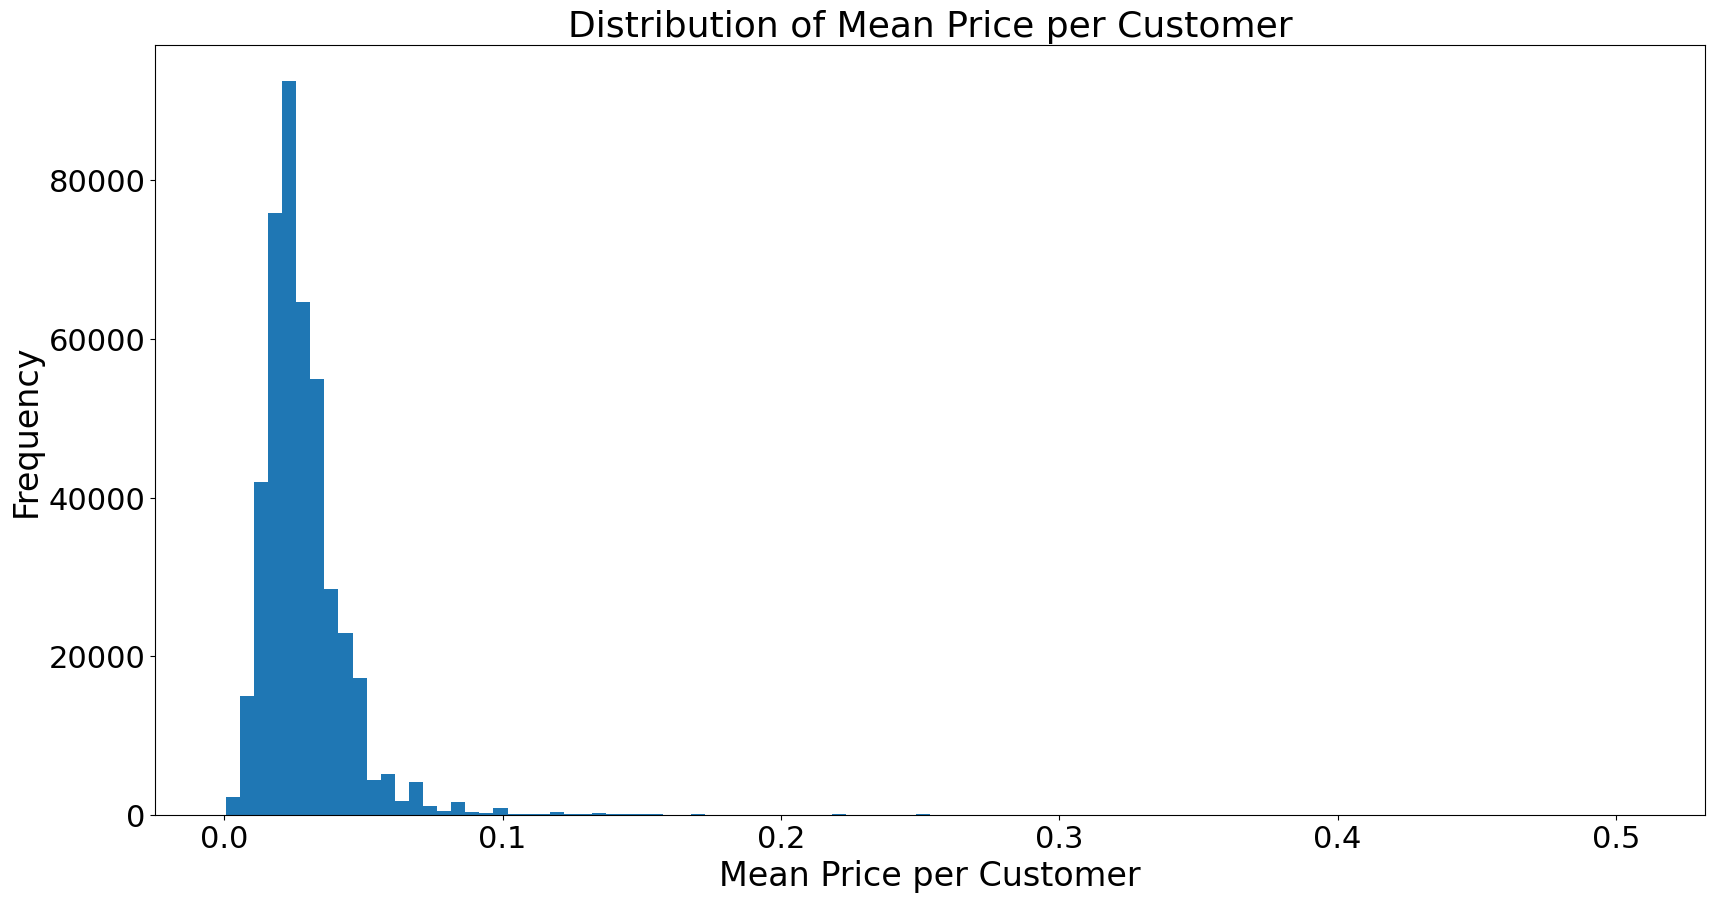

In [79]:
# create a plot to see the distribution of the mean_price_per_c column
plt.figure(figsize=(20, 10))
plt.gca().set_facecolor('white')

plt.hist(mean_price_per_c['mean_price_per_c'], bins=100)  # You can change the color code as needed

plt.title('Distribution of Mean Price per Customer', fontsize=26)
plt.xlabel('Mean Price per Customer', fontsize=24)
plt.ylabel('Frequency', fontsize=24)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.show()

In [80]:
c2index_group_name

,customer_id,highest_count_ign_per_c,count
717397,18442606110317830291,0,231
14356,371834049679164774,0,231
483365,12416564893706204993,0,196
670906,17234420386288341054,0,166
37771,979392728188584892,0,160
...,...,...,...
249873,6420757378897806626,0,1
249872,6420635653313041923,2,1
249868,6420532178711353262,2,1
528364,13570978177308658659,2,1


In [139]:
c2index_group_name.describe()

,customer_id,highest_count_ign_per_c,count
count,4.373650e+05,437365.000000,437365.000000
mean,9.222122e+18,0.710077,4.794355
std,5.321600e+18,1.195226,5.383073
min,2.884724e+13,0.000000,1.000000
25%,4.608568e+18,0.000000,2.000000
50%,9.234793e+18,0.000000,3.000000
75%,1.382773e+19,2.000000,6.000000
max,1.844674e+19,4.000000,231.000000


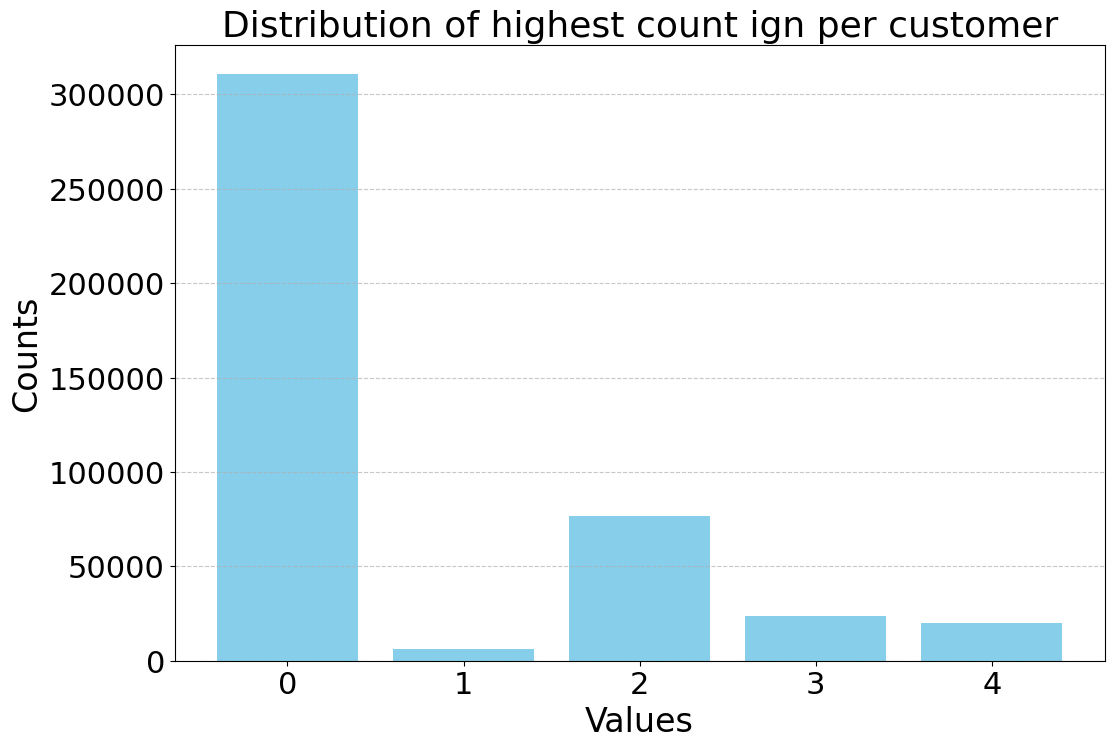

In [81]:
# Create plot to see the distribution of the highest_count_ign_per_c column
unique_values, counts = np.unique(c2index_group_name['highest_count_ign_per_c'], return_counts=True)

plt.figure(figsize=(12, 8))
plt.gca().set_facecolor('white')
ax = plt.subplot()

ax.bar(unique_values, counts, color='skyblue')

ax.set_title('Distribution of highest count ign per customer', fontsize=26)
ax.set_xlabel('Values', fontsize=24)
ax.set_ylabel('Counts', fontsize=24)
ax.set_xticks(unique_values)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.tick_params(axis='both', which='major', labelsize=22)

plt.show()

In [82]:
mean_age_per_article

,article_id,mean_age_per_a
0,108775015,40
1,108775044,38
2,110065001,36
3,110065002,27
4,110065011,27
...,...,...
38326,952267001,34
38327,952938001,36
38328,953450001,33
38329,953763001,36


In [83]:
mean_age_per_article.describe()

,article_id,mean_age_per_a
count,3.833100e+04,38331.000000
mean,7.730169e+08,35.753463
std,1.237339e+08,7.466181
min,1.087750e+08,17.000000
25%,7.166540e+08,31.000000
50%,8.053700e+08,35.000000
75%,8.638470e+08,39.000000
max,9.562170e+08,98.000000


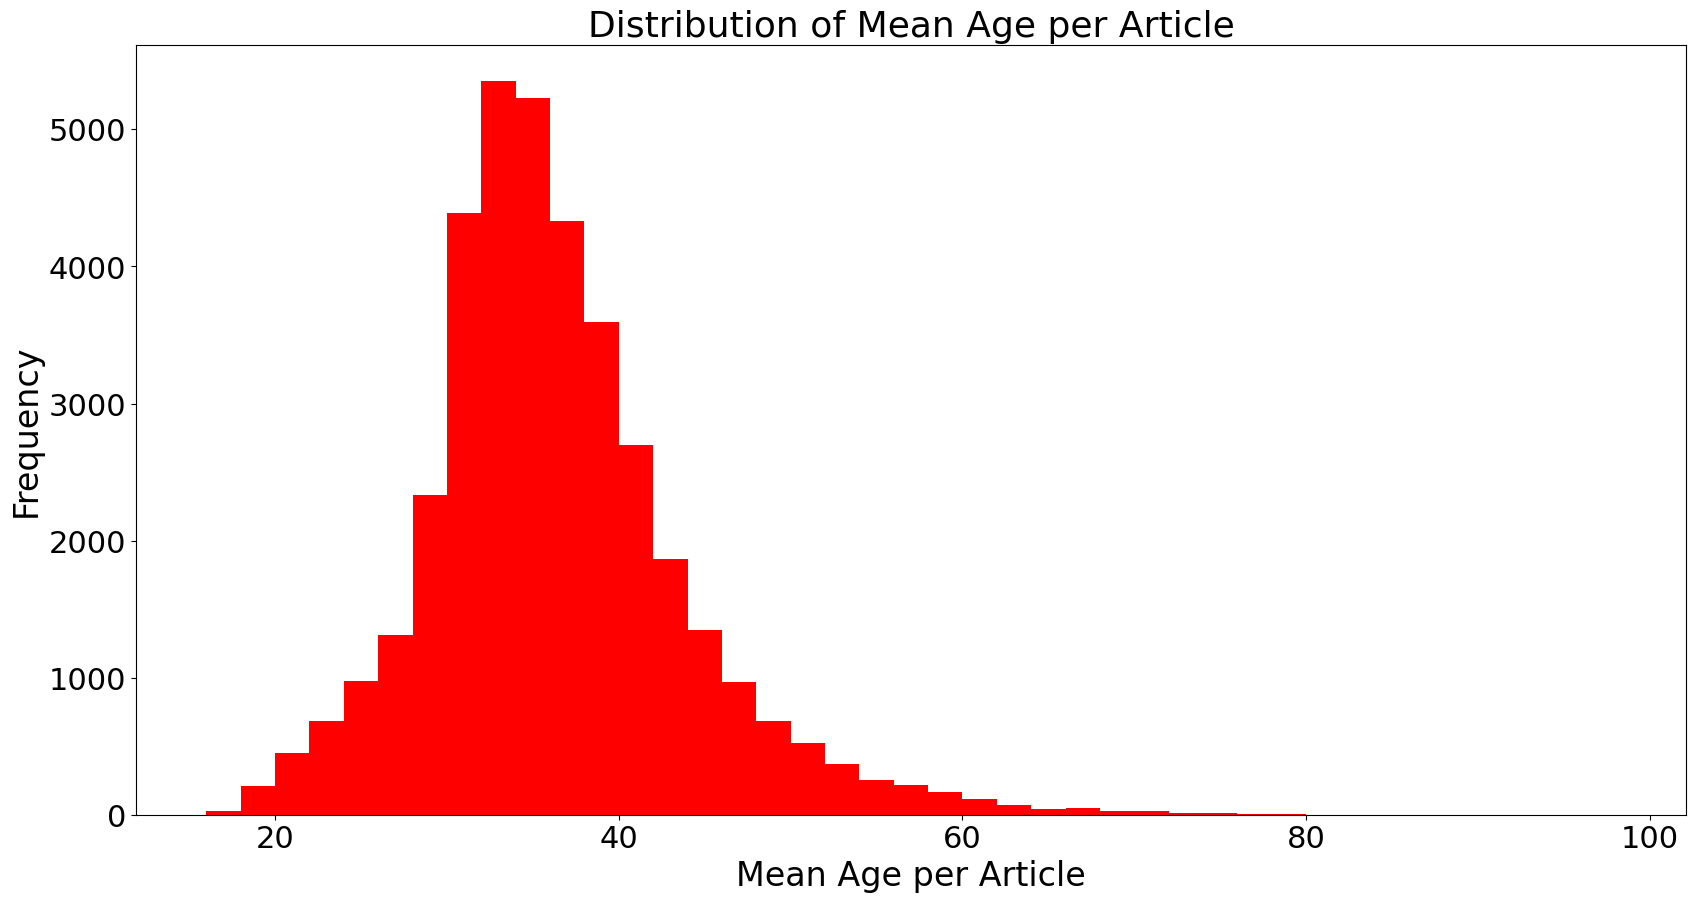

In [84]:
# Create plot to see the distribution of the mean age per article column
plt.figure(figsize=(20, 10))
plt.gca().set_facecolor('white')

# Define bin edges for 2-year intervals, min=17 years old, max=98 years old
bin_edges = np.arange(16, 100, 2)

plt.hist(mean_age_per_article['mean_age_per_a'], bins=bin_edges, color='red')

plt.title('Distribution of Mean Age per Article', fontsize=26)
plt.xlabel('Mean Age per Article', fontsize=24)
plt.ylabel('Frequency', fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=22)

plt.show()

The created transactions_with_3feat is a part of the transactions dataframe with among other important columns the three feature columns: mean_price_per_c, highest_count_ign_per_c and mean_age_per_a.

In [85]:
transactions_with_3feat

,t_dat,customer_id,article_id,price,sales_channel_id,week,age,highest_count_ign_per_c,mean_price_per_c,mean_age_per_a,index_group_name
0,2020-07-15,272412481300040,778064028,0.008458,1,95,48.0,0,0.030597,32,0
1,2020-07-15,272412481300040,816592008,0.016932,1,95,48.0,0,0.030597,37,2
2,2020-07-15,272412481300040,621381021,0.033881,1,95,48.0,0,0.030597,35,2
3,2020-07-15,272412481300040,817477003,0.025407,1,95,48.0,0,0.030597,33,0
4,2020-07-15,272412481300040,899088002,0.025407,1,95,48.0,0,0.030597,35,2
...,...,...,...,...,...,...,...,...,...,...,...
2762867,2020-09-22,18439937050817258297,891591003,0.084729,2,104,49.0,0,0.040379,42,0
2762868,2020-09-22,18439937050817258297,869706005,0.084729,2,104,49.0,0,0.040379,39,0
2762869,2020-09-22,18440902715633436014,918894002,0.016932,1,104,18.0,0,0.028232,30,0
2762870,2020-09-22,18440902715633436014,761269001,0.016932,1,104,18.0,0,0.028232,34,0


In [137]:
# perform a sanity check to see if transactions_with_3feat has any null values
transactions_with_3feat.isnull().sum()

t_dat                      0
customer_id                0
article_id                 0
price                      0
sales_channel_id           0
week                       0
age                        0
highest_count_ign_per_c    0
mean_price_per_c           0
mean_age_per_a             0
index_group_name           0
dtype: int64

In [138]:
# perform a sanity check to see if transactions_with_3feat has any nan values
transactions_with_3feat.isna().sum()

t_dat                      0
customer_id                0
article_id                 0
price                      0
sales_channel_id           0
week                       0
age                        0
highest_count_ign_per_c    0
mean_price_per_c           0
mean_age_per_a             0
index_group_name           0
dtype: int64

In [142]:
# perform a sanity check to see if transactions_with_3feat has any duplicates
transactions_with_3feat.duplicated().sum()

233732

In [144]:
transactions.duplicated().sum()

233732

The above can be possible because customers can buy the same article multiple times (same number as amount of duplicated in the transactions dataset, so it's fine). We can see that the mean_price_per_c and highest_count_ign_per_c columns have 0 null values and 0 nan values. The mean_age_per_a column also has 0 null values and 0 nan values.

### 3 feature candidates
Here, I generate personalized candidates for each customer based on three feature columns: mean age per article, highest index_group_name count and mean purchase price of the customer.

In [86]:
# merge t with customers columns customer_id, age on customer_id for later use
t_merged: pd.DataFrame = pd.merge(transactions_with_2feat, customers[['customer_id', 'age']], on='customer_id', how='left')
# Create a DataFrame with unique articles
unique_articles: pd.DataFrame = transactions_with_3feat[['t_dat', 'sales_channel_id', 'article_id', 'price', 'index_group_name', 'week']].drop_duplicates()
# we only keep latest purchase of each article
unique_articles: pd.DataFrame = unique_articles.sort_values('t_dat', ascending=False).drop_duplicates('article_id')

unique_customers: List[int] = mean_price_per_c['customer_id'].unique()[:1000]
chunk_size: int = 1000  # Define the number of customers to process at once
chunks: List[List[int]] = [unique_customers[i:i + chunk_size] for i in range(0, len(unique_customers), chunk_size)]
topX_price: int = 50 # top x candidates to be filtered by price columns
topX_age: int = 25 # top x candidates to be filtered by age columns

top_candidates_3feat: pd.DataFrame = get_candidates(chunks, unique_articles, t_merged, mean_age_per_article, topX_price, topX_age)

Chunk 0 processed in 22.20 seconds


In [87]:
top_candidates_3feat

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
0,2020-07-16,1,754852002,0.050831,0,95,28847241659200,0,0.046085,21.0,21,21.0,1.0
1,2020-07-21,1,747764002,0.047441,0,95,28847241659200,0,0.046085,21.0,22,2.0,2.0
2,2020-07-16,1,685944002,0.042356,0,95,28847241659200,0,0.046085,21.0,20,7.0,2.0
3,2020-07-19,1,746344001,0.033881,0,95,28847241659200,0,0.046085,21.0,20,36.0,2.0
4,2020-07-15,1,796042001,0.033881,0,95,28847241659200,0,0.046085,21.0,22,36.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2020-09-22,1,911034002,0.021678,2,104,42984229297455520,2,0.021452,18.0,32,12.0,21.0
249996,2020-09-22,1,670698020,0.021169,2,104,42984229297455520,2,0.021452,18.0,32,13.0,21.0
249997,2020-09-22,1,858883001,0.021169,2,104,42984229297455520,2,0.021452,18.0,32,13.0,21.0
249998,2020-09-22,1,884405005,0.021169,2,104,42984229297455520,2,0.021452,18.0,32,13.0,21.0


In [88]:
top_candidates_3feat[top_candidates_3feat['customer_id'] == 272412481300040]

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
1250,2020-07-20,1,578317003,0.027102,0,95,272412481300040,0,0.030597,48.0,48,26.0,1.0
1251,2020-07-18,1,690803001,0.033881,0,95,272412481300040,0,0.030597,48.0,47,11.0,2.0
1252,2020-07-17,1,559626001,0.025424,0,95,272412481300040,0,0.030597,48.0,47,45.0,2.0
1253,2020-07-21,2,594834018,0.030492,0,95,272412481300040,0,0.030597,48.0,46,1.0,4.0
1254,2020-07-15,2,757333004,0.030492,0,95,272412481300040,0,0.030597,48.0,50,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2020-09-22,2,890766002,0.030492,0,104,272412481300040,0,0.030597,48.0,34,4.0,19.0
1496,2020-09-22,1,843380004,0.030492,0,104,272412481300040,0,0.030597,48.0,34,4.0,19.0
1497,2020-09-22,2,871974001,0.030492,0,104,272412481300040,0,0.030597,48.0,34,4.0,19.0
1498,2020-09-22,1,883689001,0.030492,0,104,272412481300040,0,0.030597,48.0,34,4.0,19.0


We see above that the number of rows per customer, is equal to 10 times the topX_age variable, which is correct since this variable determines how many candidates we want to generate per customer, and we have 10 weeks of training data. It is also correct that top_candidates_3feat in total has 1000 times this number of rows, since we have selected 1000 customers in unique_customers. I made the order in which I filter the candidates in the candidate generation method in such a way so that every customer for which candidates are generated, will have the same number of candidates generated for them. This is why we see that the number of rows per customer is the same for every customer.

In [89]:
top_candidates_3feat_prev_week = top_candidates_3feat.copy()
del top_candidates_3feat
top_candidates_3feat_prev_week.week += 1 # since the candidates are generated for the previous week, the max week number will now be 105

In [90]:
top_candidates_3feat_prev_week

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
0,2020-07-16,1,754852002,0.050831,0,96,28847241659200,0,0.046085,21.0,21,21.0,1.0
1,2020-07-21,1,747764002,0.047441,0,96,28847241659200,0,0.046085,21.0,22,2.0,2.0
2,2020-07-16,1,685944002,0.042356,0,96,28847241659200,0,0.046085,21.0,20,7.0,2.0
3,2020-07-19,1,746344001,0.033881,0,96,28847241659200,0,0.046085,21.0,20,36.0,2.0
4,2020-07-15,1,796042001,0.033881,0,96,28847241659200,0,0.046085,21.0,22,36.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,2020-09-22,1,911034002,0.021678,2,105,42984229297455520,2,0.021452,18.0,32,12.0,21.0
249996,2020-09-22,1,670698020,0.021169,2,105,42984229297455520,2,0.021452,18.0,32,13.0,21.0
249997,2020-09-22,1,858883001,0.021169,2,105,42984229297455520,2,0.021452,18.0,32,13.0,21.0
249998,2020-09-22,1,884405005,0.021169,2,105,42984229297455520,2,0.021452,18.0,32,13.0,21.0


### Calculate mean recall of the generated 3 feature candidates
We use the last week as validation data.

In [91]:
recall_last_week: float = calculate_recall_per_customer_batch(validation, top_candidates_3feat_prev_week, unique_customers, topX_age)

Recall Score on Candidates for Last Week: 0.0


In [92]:
unique_transactions_ = transactions.groupby(['week', 'customer_id']).head(1).drop(columns=['article_id', 'price']).copy()
candidates_ = top_candidates_3feat_prev_week.copy()
candidates_.drop(columns=['price_rank', 'age_rank', 'highest_count_ign_per_c', 'mean_price_per_c', 'index_group_name', 'mean_age_per_a', 'age'], inplace=True)

In [93]:
candidates_

,t_dat,sales_channel_id,article_id,price,week,customer_id
0,2020-07-16,1,754852002,0.050831,96,28847241659200
1,2020-07-21,1,747764002,0.047441,96,28847241659200
2,2020-07-16,1,685944002,0.042356,96,28847241659200
3,2020-07-19,1,746344001,0.033881,96,28847241659200
4,2020-07-15,1,796042001,0.033881,96,28847241659200
...,...,...,...,...,...,...
249995,2020-09-22,1,911034002,0.021678,105,42984229297455520
249996,2020-09-22,1,670698020,0.021169,105,42984229297455520
249997,2020-09-22,1,858883001,0.021169,105,42984229297455520
249998,2020-09-22,1,884405005,0.021169,105,42984229297455520


In [94]:
transactions['purchased'] = 1
data = pd.concat([transactions, candidates_last_purchase, candidates_])
data.purchased.fillna(0, inplace=True)
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [95]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0
...,...,...,...,...,...,...,...
249995,2020-09-22,42984229297455520,911034002,0.021678,1,105,0.0
249996,2020-09-22,42984229297455520,670698020,0.021169,1,105,0.0
249997,2020-09-22,42984229297455520,858883001,0.021169,1,105,0.0
249998,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0


In [96]:
data = pd.merge(
    data,
    top_candidates_3feat_prev_week[['week', 'article_id', 'price_rank', 'age_rank']],
    on=['week', 'article_id'],
    how='left'
)
data = data[data.week != data.week.min()]
data.price_rank.fillna(999, inplace=True)
data.age_rank.fillna(999, inplace=True)

In [97]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank
261987,2020-07-22,200292573348128,880777001,0.025407,2,96,1.0,999.0,999.0
261988,2020-07-22,200292573348128,784332002,0.025407,2,96,1.0,999.0,999.0
261989,2020-07-22,200292573348128,827968001,0.016932,2,96,1.0,999.0,999.0
261990,2020-07-22,200292573348128,599580086,0.011847,2,96,1.0,999.0,999.0
261991,2020-07-22,248294615847351,720504008,0.031458,1,96,1.0,999.0,999.0
...,...,...,...,...,...,...,...,...,...
16976526,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0,1.0,23.0
16976527,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0,1.0,23.0
16976528,2020-09-22,42984229297455520,884405005,0.021169,1,105,0.0,13.0,21.0
16976529,2020-09-20,42984229297455520,850622002,0.021169,1,105,0.0,1.0,21.0


In [98]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [99]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [100]:
train

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-26,28847241659200,887770001,0.016932,1,96,1.0,999.0,999.0,887770,...,10,1010,6,3692,1,1,0,1,21.0,57896
1,2020-07-18,28847241659200,762846001,0.025407,1,96,0.0,999.0,999.0,762846,...,7,1010,6,492,1,1,0,1,21.0,57896
2,2020-07-18,28847241659200,829308001,0.033881,1,96,0.0,999.0,999.0,829308,...,21,1005,0,9082,1,1,0,1,21.0,57896
3,2020-07-16,28847241659200,754852002,0.050831,1,96,0.0,21.0,1.0,754852,...,45,1001,10,17015,1,1,0,1,21.0,57896
4,2020-07-16,28847241659200,754852002,0.050831,1,96,0.0,5.0,1.0,754852,...,45,1001,10,17015,1,1,0,1,21.0,57896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12318257,2020-09-20,18445641720816255142,923037003,0.033881,2,104,1.0,999.0,999.0,923037,...,31,1017,4,10043,1,1,0,1,31.0,147613
12318258,2020-09-21,18446737527580148316,547780001,0.023712,2,104,1.0,999.0,999.0,547780,...,27,1002,2,271,1,1,0,1,60.0,96323
12318259,2020-09-21,18446737527580148316,763988001,0.023712,2,104,1.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60.0,96323
12318260,2020-09-21,18446737527580148316,763988003,0.023712,2,104,1.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60.0,96323


Below is one of the tests I did to check why my recall was 0.0. The goal was to see what were the characteristics of the articles that the customer actually bought vs the characteristics of the articles that were generated as candidates for the customer. After different prints, I found out that the articles that were generated as candidates for the customer were too perfect for the customer. Some customers buy articles where the difference between the age of the customer and the mean age of the article are relatively high or where the price of the article is relatively high/low compared to the mean price of the customer. This is mentioned in the report.

In [101]:
# get the row from mean_age_per_article with article_id == 885951001
mean_age_per_article[mean_age_per_article['article_id'] == 885951001]

,article_id,mean_age_per_a
33131,885951001,31


In [102]:
# get the rows from train with article_id in [885951001, 611415001] and customer_id in [1402273113592184]
train[(train['article_id'].isin([885951001, 611415001])) & (train['customer_id'] == 1402273113592184)]

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
11493565,2020-09-22,1402273113592184,885951001,0.030492,2,104,1.0,999.0,999.0,885951,...,5,1017,4,5645,-1,-1,0,0,20.0,206442
11493566,2020-09-22,1402273113592184,611415001,0.016932,2,104,1.0,999.0,999.0,611415,...,5,1017,4,28,-1,-1,0,0,20.0,206442


In [103]:
# get the row from top_candidates_3feat_prev_week with customer_id == 1402273113592184
top_candidates_3feat_prev_week[(top_candidates_3feat_prev_week['customer_id'] == 1402273113592184) & (top_candidates_3feat_prev_week['week'] == 104)]

,t_dat,sales_channel_id,article_id,price,index_group_name,week,customer_id,highest_count_ign_per_c,mean_price_per_c,age,mean_age_per_a,price_rank,age_rank
8450,2020-09-09,2,822396002,0.023712,0,104,1402273113592184,0,0.023712,20.0,22,1.0,1.0
8451,2020-09-10,1,699303001,0.024390,0,104,1402273113592184,0,0.023712,20.0,24,41.0,2.0
8452,2020-09-09,1,873678012,0.023780,0,104,1402273113592184,0,0.023712,20.0,25,34.0,3.0
8453,2020-09-10,1,758034012,0.023034,0,104,1402273113592184,0,0.023712,20.0,27,40.0,4.0
8454,2020-09-15,1,868629001,0.024390,0,104,1402273113592184,0,0.023712,20.0,27,41.0,4.0
8455,2020-09-12,1,791663002,0.022864,0,104,1402273113592184,0,0.023712,20.0,27,45.0,4.0
8456,2020-09-15,2,781403002,0.023712,0,104,1402273113592184,0,0.023712,20.0,28,1.0,7.0
8457,2020-09-15,2,699423003,0.023712,0,104,1402273113592184,0,0.023712,20.0,28,1.0,7.0
8458,2020-09-13,2,702293001,0.023712,0,104,1402273113592184,0,0.023712,20.0,28,1.0,7.0
8459,2020-09-13,2,775423002,0.023712,0,104,1402273113592184,0,0.023712,20.0,29,1.0,10.0


In [104]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,price_rank,age_rank,product_code,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
12318262,2020-09-03,28847241659200,925246001,0.128797,2,105,0.0,999.0,999.0,925246,...,40,1007,9,27855,1,1,0,1,21.0,57896
12318263,2020-09-22,28847241659200,779068002,0.045746,2,105,0.0,7.0,1.0,779068,...,10,1003,3,15430,1,1,0,1,21.0,57896
12318270,2020-09-22,28847241659200,754323004,0.045746,2,105,0.0,7.0,2.0,754323,...,0,1003,3,4874,1,1,0,1,21.0,57896
12318277,2020-09-22,28847241659200,721481003,0.045746,2,105,0.0,7.0,3.0,721481,...,0,1010,6,11900,1,1,0,1,21.0,57896
12318284,2020-09-22,28847241659200,904225001,0.045746,1,105,0.0,7.0,3.0,904225,...,20,1020,7,26543,1,1,0,1,21.0,57896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714534,2020-09-06,18446705133201055310,875784002,0.050831,2,105,0.0,999.0,999.0,875784,...,15,1003,3,11763,1,1,0,1,60.0,177867
16714535,2020-09-21,18446737527580148316,547780001,0.023712,2,105,0.0,13.0,16.0,547780,...,27,1002,2,271,1,1,0,1,60.0,96323
16714538,2020-09-21,18446737527580148316,763988001,0.023712,2,105,0.0,1.0,17.0,763988,...,16,1002,2,1107,1,1,0,1,60.0,96323
16714540,2020-09-21,18446737527580148316,763988003,0.023712,2,105,0.0,999.0,999.0,763988,...,16,1002,2,1107,1,1,0,1,60.0,96323


In [105]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [106]:
train_baskets

array([2165, 2128, 3605, ...,    2,    7,    4], dtype=int64)

In [107]:
extra_columns = ['price_rank', 'age_rank']
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
columns_to_use.extend(extra_columns)

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [108]:
test_X

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,price_rank,age_rank
12318262,925246001,262,1010016,9,4,5,1201,0,1,19,1007,1,1,0,1,21.0,57896,999.0,999.0
12318263,779068002,252,1010016,13,2,11,1610,0,1,6,1003,1,1,0,1,21.0,57896,7.0,1.0
12318270,754323004,252,1010010,14,4,11,1626,0,1,15,1003,1,1,0,1,21.0,57896,7.0,2.0
12318277,721481003,258,1010017,73,2,6,1522,0,1,15,1010,1,1,0,1,21.0,57896,7.0,3.0
12318284,904225001,87,1010016,9,4,5,3529,6,1,64,1020,1,1,0,1,21.0,57896,7.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714534,875784002,252,1010016,9,4,12,1949,0,1,2,1003,1,1,0,1,60.0,177867,999.0,999.0
16714535,547780001,272,1010016,9,4,5,1643,1,2,51,1002,1,1,0,1,60.0,96323,13.0,16.0
16714538,763988001,272,1010016,9,4,5,5833,2,3,26,1002,1,1,0,1,60.0,96323,1.0,17.0
16714540,763988003,272,1010010,9,4,12,5833,2,3,26,1002,1,1,0,1,60.0,96323,999.0,999.0


# Model training and ranking

In [109]:
from lightgbm.sklearn import LGBMRanker
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())
    
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

best_last_week = \
    top_candidates_3feat_prev_week[top_candidates_3feat_prev_week.week == top_candidates_3feat_prev_week.week.max()]['article_id'].tolist()

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.888645
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.155596
[LightGBM] [Debug] init for col-wise cost 0.070097 seconds, init for row-wise cost 0.117848 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 12318262, number of used features: 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
price_rank 0.681893365021105
article_id 0.10848657620116307
product_type_no 0.08607246040132786
garment_group_no 0.06755710711986646
department_no 0.03700613438808625
section_no 0.011290109099070352
graphical_appearance_no 0.004957194050169081
colour_group_code 0.002737053719

In [110]:
sub = pd.read_csv('../../input/sample_submission.csv')
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + best_last_week
    preds.append(pred[:12])

In [111]:
# \/ Copied from NickWils
from tqdm import tqdm
# Creating validation set for metrics use case
positive_items_val = validation.groupby(['customer_id'])['article_id'].apply(list)
val_users = positive_items_val.keys()
val_items = []
for i, user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])
    
print("Total users in validation:", len(val_users))
print("mAP12 Score on Validation set:", mapk(val_items, preds))
print("recall Score on Validation set:", recall12(val_items, preds))
# /\

68984it [00:00, 422801.34it/s]


Total users in validation: 68984
mAP12 Score on Validation set: 0.00021160737487168257
recall Score on Validation set: 0.0009572076121841792


In [112]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds
sub.to_csv(f'../basic_model_submission.csv.gz', index=False)

# Radek

In [113]:
transactions = transactions_copy.copy()
del transactions_copy

In [114]:
### Bestsellers candidates
mean_price = transactions.groupby(['week', 'article_id'])['price'].mean()
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [115]:
# bestsellers_previous_week.pipe(lambda df: df[df['week']==96])
bestsellers_previous_week

,week,article_id,bestseller_rank,price
0,96,760084003,1,0.025094
1,96,866731001,2,0.024919
2,96,600886001,3,0.022980
3,96,706016001,4,0.033197
4,96,372860002,5,0.013193
...,...,...,...,...
115,105,915529003,8,0.033439
116,105,915529005,9,0.033417
117,105,448509014,10,0.041630
118,105,762846027,11,0.025005


In [116]:
unique_transactions = transactions.groupby(['week', 'customer_id']).head(1).drop(columns=['article_id', 'price']).copy()
candidates_bestsellers = pd.merge(unique_transactions, bestsellers_previous_week, on='week',)
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [117]:
candidates_bestsellers

In [119]:
candidates_bestsellers_test_week = pd.merge(test_set_transactions, bestsellers_previous_week, on='week')
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [120]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-22,200292573348128,2,96,760084003,0.025094
1,2020-07-22,200292573348128,2,96,866731001,0.024919
2,2020-07-22,200292573348128,2,96,600886001,0.022980
3,2020-07-22,200292573348128,2,96,706016001,0.033197
4,2020-07-22,200292573348128,2,96,372860002,0.013193
...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,915529003,0.033439
5248376,2020-09-22,18438270306572912089,1,105,915529005,0.033417
5248377,2020-09-22,18438270306572912089,1,105,448509014,0.041630
5248378,2020-09-22,18438270306572912089,1,105,762846027,0.025005


# Combining transactions and candidates / negative examples

In [121]:
transactions['purchased'] = 1
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [122]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0
...,...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,915529003,0.033439,1,105,0.0
5248376,2020-09-22,18438270306572912089,915529005,0.033417,1,105,0.0
5248377,2020-09-22,18438270306572912089,448509014,0.041630,1,105,0.0
5248378,2020-09-22,18438270306572912089,762846027,0.025005,1,105,0.0


### Add bestseller information

In [123]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [124]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [125]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
11381612,2020-09-03,28847241659200,925246001,0.128797,2,105,0.0,999.0,925246,25454,...,40,1007,9,27855,1,1,0,1,21.0,57896
11381613,2020-07-18,28847241659200,924243001,0.041535,1,105,0.0,1.0,924243,19190,...,0,1003,3,13007,1,1,0,1,21.0,57896
11381614,2020-07-18,28847241659200,924243002,0.041877,1,105,0.0,2.0,924243,19190,...,0,1003,3,13007,1,1,0,1,21.0,57896
11381615,2020-07-18,28847241659200,918522001,0.041435,1,105,0.0,3.0,918522,26372,...,0,1003,3,28633,1,1,0,1,21.0,57896
11381616,2020-07-18,28847241659200,923758001,0.033462,1,105,0.0,4.0,923758,19359,...,0,1010,6,27869,1,1,0,1,21.0,57896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991757,2020-09-21,18446737527580148316,915529003,0.033439,2,105,0.0,8.0,915529,7046,...,0,1003,3,10909,1,1,0,1,60.0,96323
17991758,2020-09-21,18446737527580148316,915529005,0.033417,2,105,0.0,9.0,915529,7046,...,0,1003,3,10909,1,1,0,1,60.0,96323
17991759,2020-09-21,18446737527580148316,448509014,0.041630,2,105,0.0,10.0,448509,259,...,1,1009,5,255,1,1,0,1,60.0,96323
17991760,2020-09-21,18446737527580148316,762846027,0.025005,2,105,0.0,11.0,762846,472,...,7,1010,6,492,1,1,0,1,60.0,96323


In [126]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [127]:
train_baskets

array([15, 23, 16, ..., 14, 19, 16], dtype=int64)

In [128]:
extra_columns = []
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']
columns_to_use.extend(extra_columns)

In [129]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [130]:
test_X

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,bestseller_rank
11381612,925246001,262,1010016,9,4,5,1201,0,1,19,1007,1,1,0,1,21.0,57896,999.0
11381613,924243001,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,21.0,57896,1.0
11381614,924243002,252,1010016,9,4,5,1626,0,1,15,1003,1,1,0,1,21.0,57896,2.0
11381615,918522001,252,1010016,11,3,9,1626,0,1,15,1003,1,1,0,1,21.0,57896,3.0
11381616,923758001,-1,1010016,10,3,9,1522,0,1,15,1010,1,1,0,1,21.0,57896,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991757,915529003,252,1010016,9,4,5,1626,0,1,15,1003,1,1,0,1,60.0,96323,8.0
17991758,915529005,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,60.0,96323,9.0
17991759,448509014,272,1010016,72,3,2,1747,1,2,53,1009,1,1,0,1,60.0,96323,10.0
17991760,762846027,259,1010016,13,1,1,1515,0,1,11,1010,1,1,0,1,60.0,96323,11.0


# Model training

In [131]:
from lightgbm.sklearn import LGBMRanker
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848850
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.153113
[LightGBM] [Debug] init for col-wise cost 0.100945 seconds, init for row-wise cost 0.095344 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 11381612, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13


In [132]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9989818311973465
age 0.00023376938753314565
article_id 0.000159500755738357
garment_group_no 0.00014551533567987764
department_no 9.635935467223185e-05
product_type_no 9.033563072641039e-05
section_no 7.076104191712535e-05
club_member_status 6.951893539114973e-05
postal_code 6.839450516512972e-05
colour_group_code 5.369694669522661e-05
perceived_colour_value_id 1.7759156334173075e-05
Active 1.255775280070197e-05
fashion_news_frequency 0.0
FN 0.0
index_code 0.0
perceived_colour_master_id 0.0
graphical_appearance_no 0.0
index_group_no 0.0


# Calculate predictions

In [133]:
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

# Create submission

In [134]:
sub = pd.read_csv('../../input/sample_submission.csv')
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

In [135]:
# \/ Copied from NickWils
from tqdm import tqdm
positive_items_val = validation.groupby(['customer_id'])['article_id'].apply(list)
# creating validation set for metrics use case
val_users = positive_items_val.keys()
val_items = []
for i, user in tqdm(enumerate(val_users)):
    val_items.append(positive_items_val[user])

print("Total users in validation:", len(val_users))
print("mAP12 Score on Validation set:", mapk(val_items, preds))
print("recall Score on Validation set:", recall12(val_items, preds))
# /\

68984it [00:00, 407133.30it/s]


Total users in validation: 68984
mAP12 Score on Validation set: 0.0076937361787450375
recall Score on Validation set: 0.02593683153219089


In [136]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
# Commented out below not to overwrite the submission file
# sub.prediction = preds
# sub_name = 'basic_model_submission'
# sub.to_csv(f'{sub_name}.csv.gz', index=False)